In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass
from matplotlib import gridspec

import scipy.signal
import scipy.optimize

import os

In [2]:
# path to data files
DATA_PATH = "./data/"

# create the plot directory if it does not exist
if not os.path.exists("./plots"):
    os.makedirs("./plots")

# path to energy plots
E_PLOT_PATH = "./plots/energy-plots/"
if not os.path.exists(E_PLOT_PATH):
    os.makedirs(E_PLOT_PATH)

# path to calibration plots
CALIB_PLOT_PATH = "./plots/calib-plots/"
if not os.path.exists(CALIB_PLOT_PATH):
    os.makedirs(CALIB_PLOT_PATH)

# path to comparison plots 
COMP_PLOT_PATH = "./plots/comp-plots/"
if not os.path.exists(COMP_PLOT_PATH):
    os.makedirs(COMP_PLOT_PATH)

# reference energies
E_CM = 5805
E_AM = 5486
E_PU = 5155

# digitizers
BOARD_1_ID = 2
BOARD_2_ID = 3
BOARD_3_ID = 4
BOARD_4_ID = 5

# strips
STRIP_1_ID = 0
STRIP_2_ID = 1
STRIP_3_ID = 2
STRIP_4_ID = 3
STRIP_5_ID = 4
STRIP_6_ID = 5
STRIP_7_ID = 6

# channels
STARTING_CHANNEL = 0
N_CHANNELS_BOARD = 16
N_CHANNELS_STRIP = 8

# energy filters
E_MIN = 3000
E_MAX = 4000

# plot stuff
FONTSIZE = 22

# save figure flag
SAVE_FIG = False

In [3]:
@dataclass
class DataFormat:
    """Holds the structure of the .root file"""
    
    root_tree : str = "Data_R"
    
    channel   : str = "Channel"
    board     : str = "Board"
    flag      : str = "Flags"
    time      : str = "Timestamp"
    energy    : str = "Energy"
    
    @property
    def to_channel(self):
        return f"{self.root_tree}/{self.channel}"
    
    @property
    def to_board(self):
        return f"{self.root_tree}/{self.board}"
    
    @property
    def to_flag(self):
        return f"{self.root_tree}/{self.flag}"
    
    @property
    def to_time(self):
        return f"{self.root_tree}/{self.time}"
    
    @property
    def to_energy(self):
        return f"{self.root_tree}/{self.energy}"

In [4]:
data_fname  = "DataR_run_1.root"
data_format = DataFormat()

with uproot.open(f"{DATA_PATH}/{data_fname}") as data_file:
    channels = data_file[data_format.to_channel].array().to_numpy()
    boards   = data_file[data_format.to_board].array().to_numpy()
    flags    = data_file[data_format.to_flag].array().to_numpy()
    time     = data_file[data_format.to_time].array().to_numpy()
    energy   = data_file[data_format.to_energy].array().to_numpy()

df = pd.DataFrame({"board":boards, "channel":channels, "flag":flags, "timestamp":time, "energy":energy})

# create a strip tag
df.loc[((df["board"] == BOARD_1_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_1_ID
df.loc[((df["board"] == BOARD_1_ID) & (df["channel"] >= N_CHANNELS_STRIP) & (df["channel"] < 2*N_CHANNELS_STRIP)), "strip"] = STRIP_2_ID
df.loc[((df["board"] == BOARD_2_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_3_ID
df.loc[((df["board"] == BOARD_2_ID) & (df["channel"] >= N_CHANNELS_STRIP) & (df["channel"] < 2*N_CHANNELS_STRIP)), "strip"] = STRIP_4_ID
df.loc[((df["board"] == BOARD_3_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_5_ID
df.loc[((df["board"] == BOARD_3_ID) & (df["channel"] >= N_CHANNELS_STRIP) & (df["channel"] < 2*N_CHANNELS_STRIP)), "strip"] = STRIP_6_ID
df.loc[((df["board"] == BOARD_4_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_7_ID

# create a strip channel tag ranging from 0 to 7
for strip_id in range(7):
    df.loc[(df["strip"] == strip_id), "strip_ch"] = df.loc[(df["strip"] == strip_id), "channel"] - df.loc[(df["strip"] == strip_id), "channel"].unique().max() + N_CHANNELS_STRIP - 1

# convert tags to small integers
df = df.astype({"strip": "int8", "strip_ch": "int8"})

In [6]:
def filter_energy(df, emin = 3000, emax = 4000):
    return df.loc[((df["energy"] > emin) & (df["energy"] < emax)), ]

In [7]:
strip_1   = STRIP_7_ID
channel_1 = 6

emin_1 = 3200
emax_1 = 3800

df_stab_1 = filter_energy(df.loc[((df["strip"] == strip_1) & (df["strip_ch"] == channel_1)), ],  emin_1, emax_1)

df_stab_1.head()

,board,channel,flag,timestamp,energy,strip,strip_ch
8105,5,6,0,144433400000,3285,6,6
12284,5,6,0,617192936000,3696,6,6
14113,5,6,0,799372204000,3727,6,6
15640,5,6,0,963974940000,3519,6,6
21291,5,6,0,1530988820000,3732,6,6


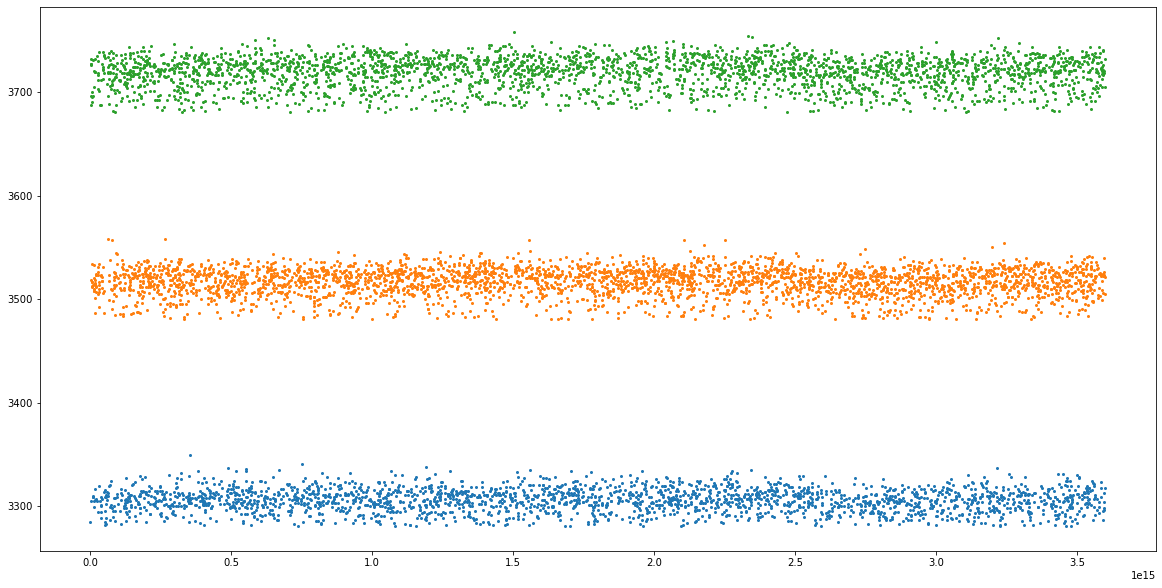

In [25]:
# split the dataset into three parts depending on the energy
df1 = df_stab_1.loc[((df_stab_1["energy"] > 3280) & (df_stab_1["energy"] < 3360)), ]
df2 = df_stab_1.loc[((df_stab_1["energy"] > 3480) & (df_stab_1["energy"] < 3560)), ]
df3 = df_stab_1.loc[((df_stab_1["energy"] > 3680) & (df_stab_1["energy"] < 3760)), ]

# plot the three parts
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(df1["timestamp"], df1["energy"], "o", markersize=2)
ax.plot(df2["timestamp"], df2["energy"], "o", markersize=2)
ax.plot(df3["timestamp"], df3["energy"], "o", markersize=2)

plt.show()

In [26]:
strip_2   = STRIP_5_ID
channel_2 = 6

emin_2 = 3200
emax_2 = 4000

df_stab_2 = filter_energy(df.loc[((df["strip"] == strip_2) & (df["strip_ch"] == channel_2)), ],  emin_2, emax_2)

df_stab_2.head()

,board,channel,flag,timestamp,energy,strip,strip_ch
6566,4,6,0,574833444000,3577,4,6
6567,4,6,0,577824736000,3631,4,6
6569,4,6,0,613315812000,3431,4,6
9323,4,6,0,979974040000,3876,4,6
10199,4,6,0,1087957652000,3822,4,6


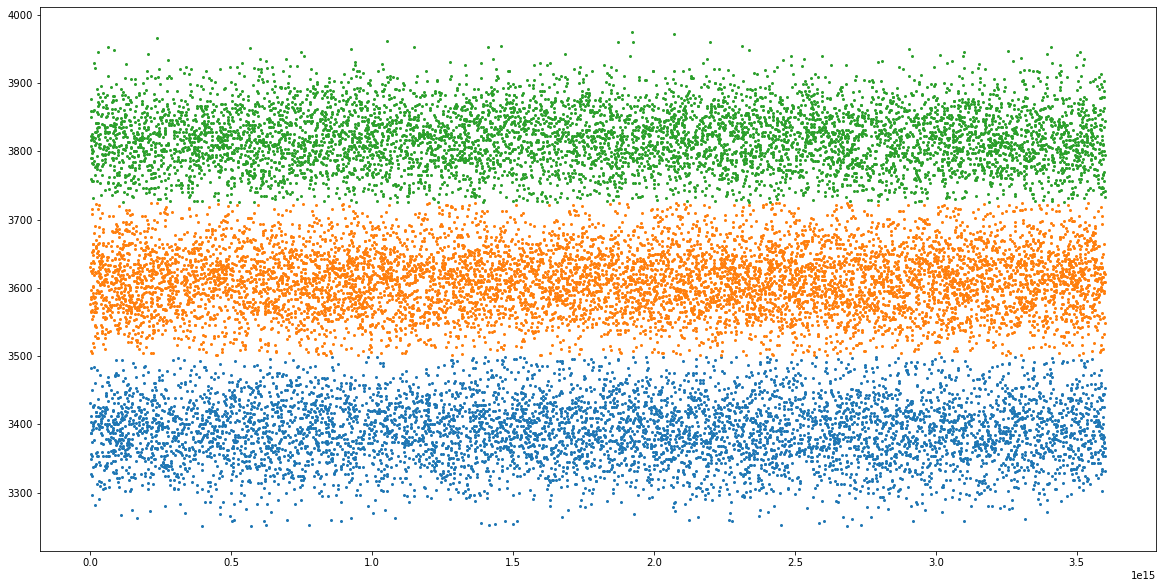

In [32]:
# split the dataset into three parts depending on the energy
df1 = df_stab_2.loc[((df_stab_2["energy"] > 3250) & (df_stab_2["energy"] < 3500)), ]
df2 = df_stab_2.loc[((df_stab_2["energy"] > 3500) & (df_stab_2["energy"] < 3725)), ]
df3 = df_stab_2.loc[((df_stab_2["energy"] > 3725) & (df_stab_2["energy"] < 4000)), ]

# plot the three parts
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(df1["timestamp"], df1["energy"], "o", markersize=2)
ax.plot(df2["timestamp"], df2["energy"], "o", markersize=2)
ax.plot(df3["timestamp"], df3["energy"], "o", markersize=2)

plt.show()